# Ensemble techniques

#### Importing relevant libraries

In [250]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.linear_model as linear_model
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix
from os import system
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
from yellowbrick.classifier import ClassificationReport, ROCAUC

### 1. Exploratory data quality report

In [181]:
# Importing data
data=pd.read_csv('../Data/bank-full.csv')

# a. Univariate analysis
print(data.shape) # Number of rows and columns in the dataframe
print(data.isnull().values.any()) # To check for null values in the dataframe
print(data.info()) # To check the data type of the columns of the dataframe
print(data.describe()) # To review the statistical summary of the dataframe
data.head()

(45211, 17)
False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
                age        balance           day      duration      campaign

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### **Insight**:
#### - The object type columns needs to be converted to categorical type variables
#### - No missing values found

In [182]:
# converting object type to categorical variables
for c in data.columns:
    if data[c].dtype=='object':
        data[c]=pd.Categorical(data[c])
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [159]:
# printing value counts of converted columns
print(data.job.value_counts()) # No particular order: One hot encoding
print(data.marital.value_counts())
print(data.education.value_counts())
print(data.default.value_counts())
print(data.housing.value_counts())
print(data.loan.value_counts())
print(data.contact.value_counts()) # No particular order: One hot encoding 
print(data.month.value_counts())
print(data.poutcome.value_counts())
print(data.Target.value_counts())

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
n

In [183]:
# Constructing array for restructuring
rstruct={'marital':{'single':0, 'married':1, 'divorced':2}, 'education':{'unknown':-1,'primary':0,'secondary':1,'tertiary':2}, 'default':{'no':0, 'yes':1}, 'housing':{'no':0, 'yes':1}, 'loan':{'no':0, 'yes':1}, 'Target':{'no':0, 'yes':1}, 'poutcome':{'unknown':-1,'failure':0, 'success':1, 'other':2}, 'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
#rstruct={"marital":{"single":0, "married":1, "divorced":2}}
onehotcol=["job","contact"]

# Replacing pdays -1 value with 900
data['pdays'].replace({-1:900}, inplace=True)

# Replacing bank data with new structure
data=data.replace(rstruct)
data=pd.get_dummies(data, columns=onehotcol)

In [184]:
# Visualizing modified dataframe 
print(data.info())
print(data.head())
print(data.describe().transpose()) # To review the statistical summary of the dataframe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                45211 non-null  int64
 1   marital            45211 non-null  int64
 2   education          45211 non-null  int64
 3   default            45211 non-null  int64
 4   balance            45211 non-null  int64
 5   housing            45211 non-null  int64
 6   loan               45211 non-null  int64
 7   day                45211 non-null  int64
 8   month              45211 non-null  int64
 9   duration           45211 non-null  int64
 10  campaign           45211 non-null  int64
 11  pdays              45211 non-null  int64
 12  previous           45211 non-null  int64
 13  poutcome           45211 non-null  int64
 14  Target             45211 non-null  int64
 15  job_admin.         45211 non-null  uint8
 16  job_blue-collar    45211 non-null  uint8
 17  job_entrepre

Univariate analysis



array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'marital'}>],
       [<AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'default'}>],
       [<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'housing'}>],
       [<AxesSubplot:title={'center':'loan'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'pdays'}>],
       [<AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'poutcome'}>],
       [<AxesSubplot:title={'center':'Target'}>,
        <AxesSubplot:title={'center':'job_admin.'}>],
       [<AxesSubplot:title={'center':'job_blue-collar'}>,
        <AxesSubplot:title={'center':'job_entrepreneur'}>],
       [<AxesSubplot:title={'center':'job_housemaid'}>,
        <AxesSubplot:titl

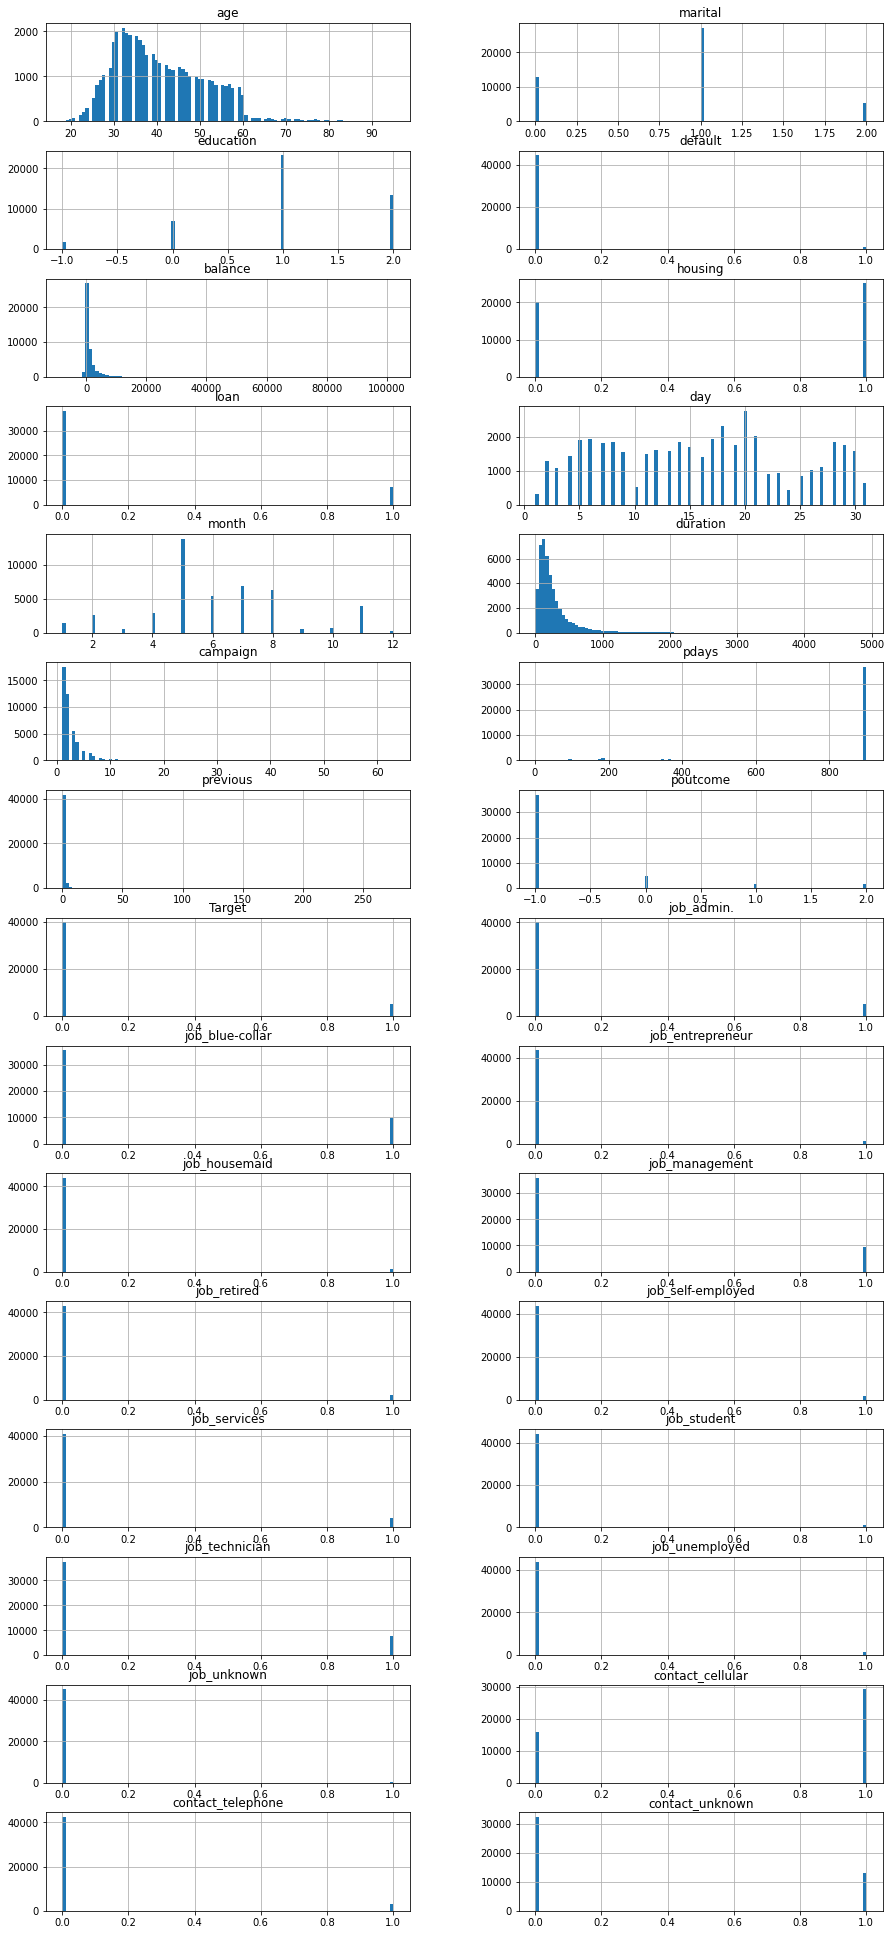

In [144]:
# Univariate analysis
print('Univariate analysis\n')
columns2stay = ['age', 'marital', 'education', 'default', 'balance', 'duration','campaign','pdays', 'poutcome','Target'] # Categorical columns
#columns2drop = ['day', 'month']
data2 = data.drop(data.columns.difference(columns2stay),1) 
data.hist(stacked=False, bins=100, figsize=(15,70), layout=(30,2))

Bivariate analysis



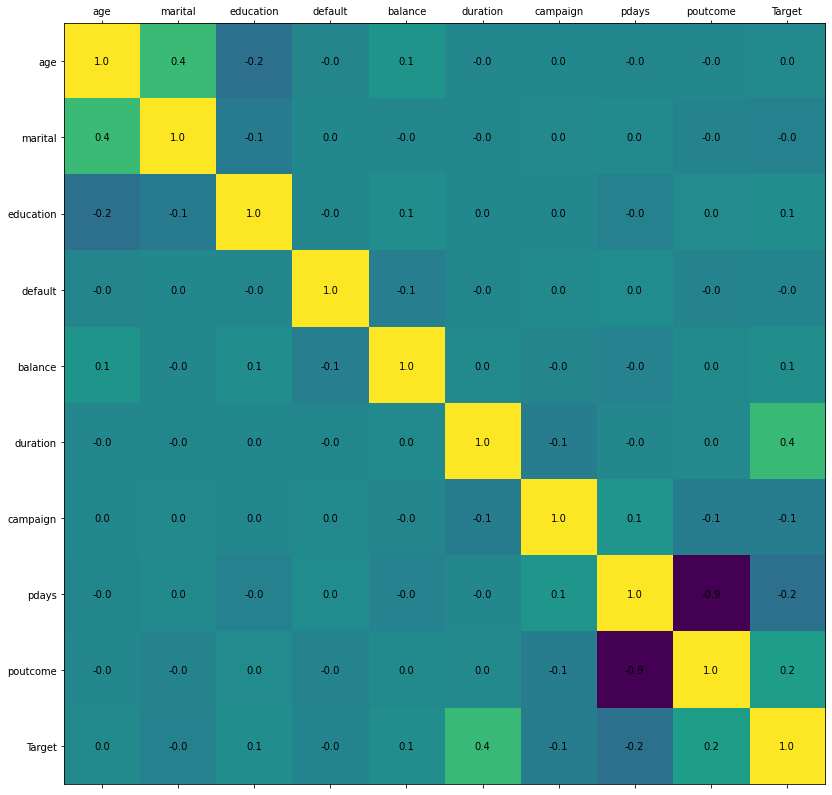

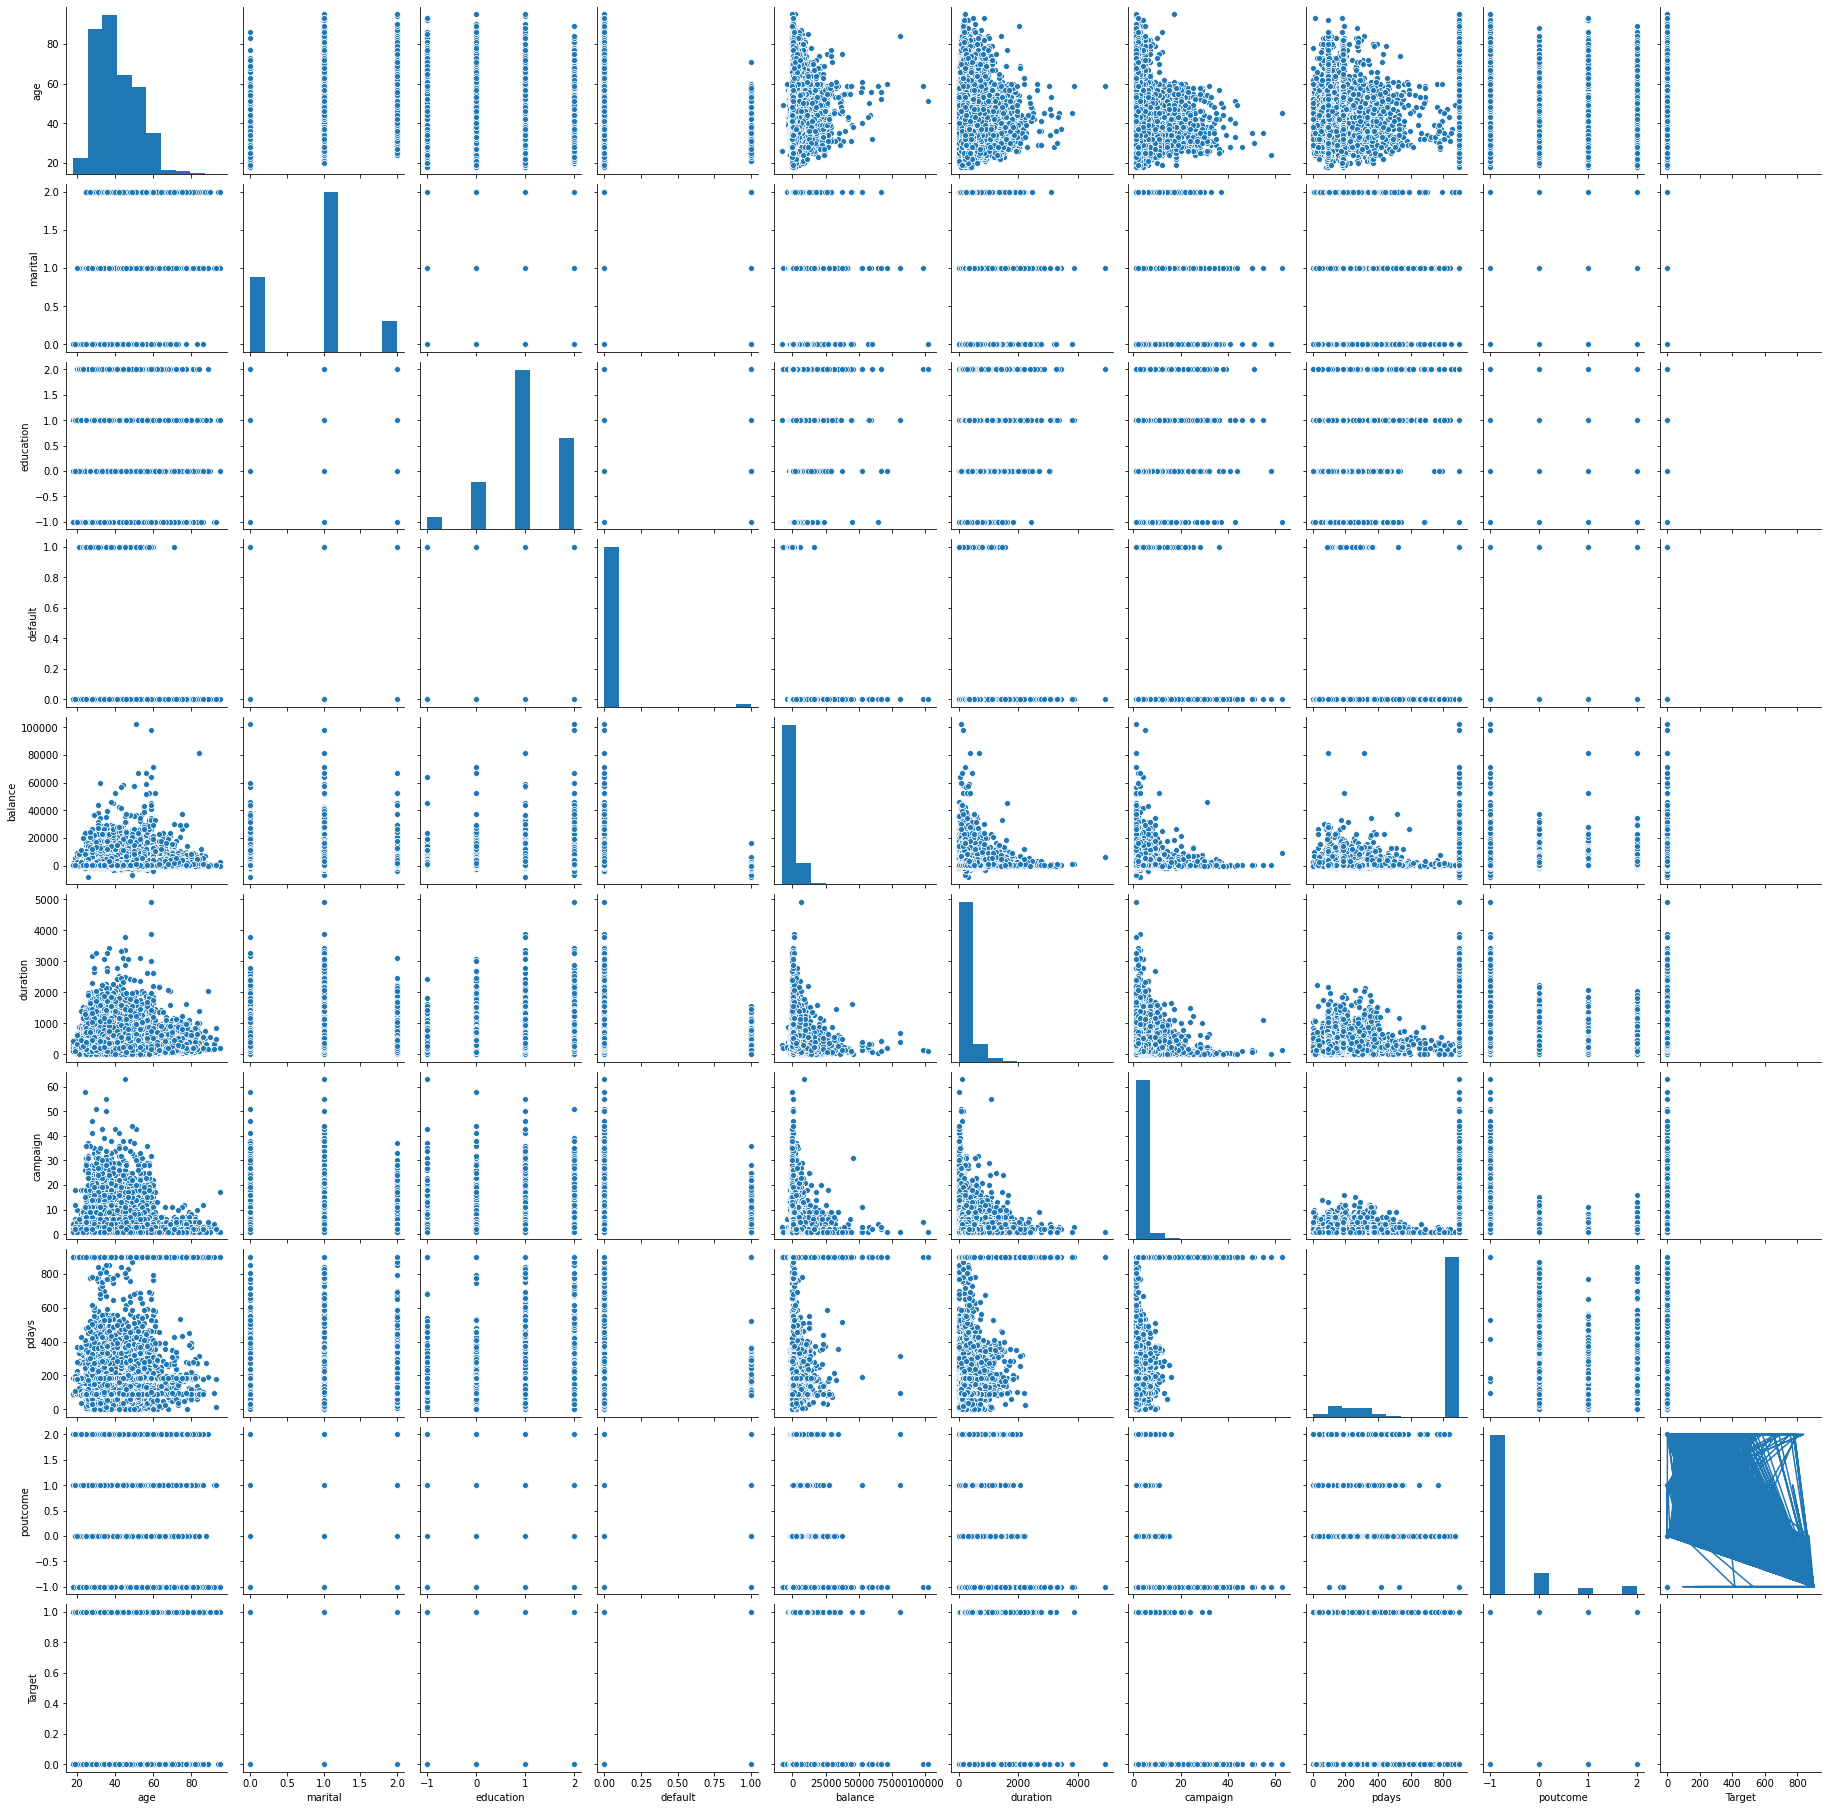

In [229]:
# Bivariate analysis
print('Bivariate analysis\n')
corr = data2.corr()
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
sns.pairplot(data2)
plt.plot(data['pdays'], data['poutcome'])

#### *Insight*: No two features are highly correlated.
#### poutcome and pdays are highly correlated in the negative sense. But since most of the data of poutcome falls under unknown (-1), no analytical insight can be made.
#### age and marital status are slightly co-related because of the way in which marital status has been converted into a categorical variable. Single -0, Married - 1, Divorced - 2.

## 2. Preparing data for analytics

### Splitting data

In [186]:
X = data.drop('Target',axis=1)
Y = data['Target']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)
print(x_train.head())
print(data2['Target'].value_counts())
print("{0:0.2f}% data is in training set".format((len(x_train)/len(data.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(data.index)) * 100))
#data['pdays'].describe()

       age  marital  education  default  balance  housing  loan  day  month  \
35272   39        0          2        0     4239        1     0    7      5   
10705   44        1          2        0      647        0     0   16      6   
43536   46        2          0        0      429        1     0   26      4   
6960    55        1          0        0       81        1     0   28      5   
41892   28        1          1        0      172        1     0   19     10   

       duration  ...  job_retired  job_self-employed  job_services  \
35272        40  ...            0                  0             0   
10705       226  ...            0                  0             0   
43536       465  ...            0                  0             0   
6960        172  ...            0                  0             0   
41892       123  ...            0                  0             0   

       job_student  job_technician  job_unemployed  job_unknown  \
35272            0               0   

## 3. Ensemble Model

#### 1. i. a. Training and testing the data for Decision Tree

In [187]:
model_entropy=DecisionTreeClassifier(criterion='gini')
model_entropy.fit(x_train, y_train)
model_entropy.score(x_train, y_train)  # performance on train data

1.0

In [188]:
model_entropy.score(x_test, y_test)  # performance on test data

0.8749631377174875

#### 1.i.  b. Pruning the decision tree and visualizing

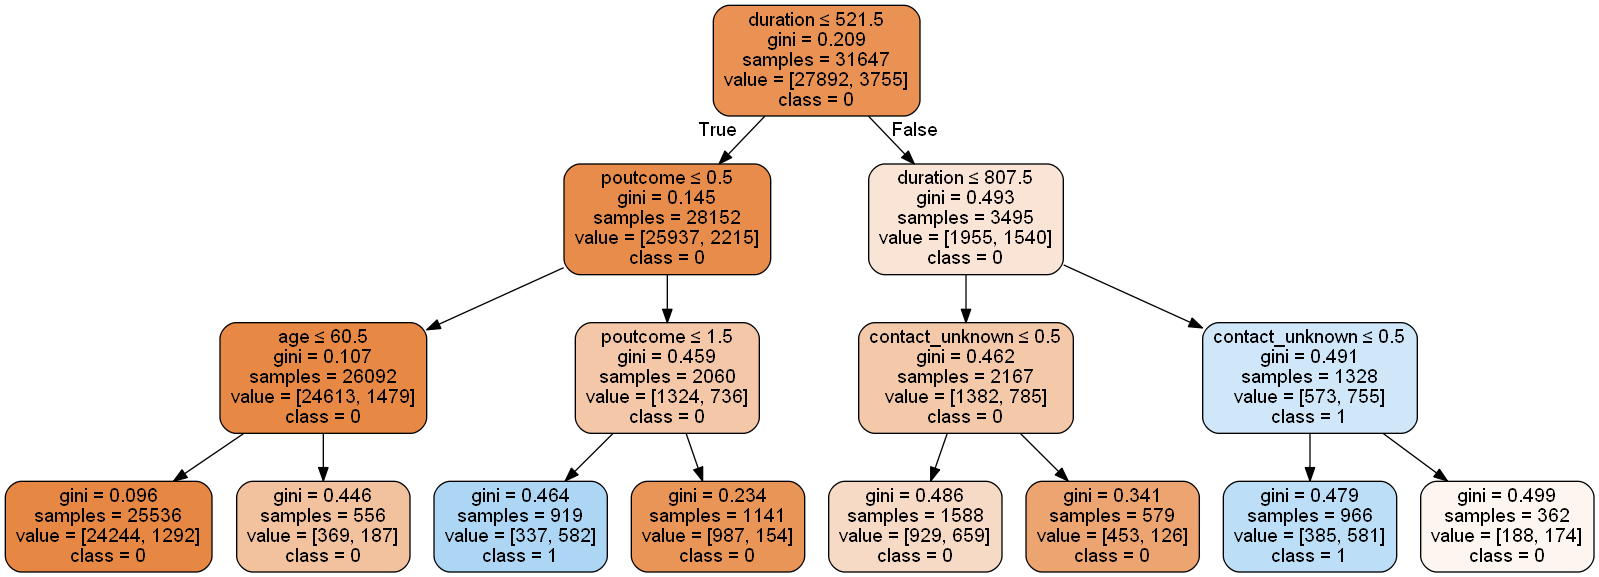

In [189]:
dt_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
dt_pruned.fit(x_train, y_train)

xvar = data.drop('Target', axis=1)
feature_cols = xvar.columns

dot_data = StringIO()
export_graphviz(dt_pruned, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bank.png')
Image(graph.create_png())

#### 1.i. c. Quality of pruned decision tree

In [219]:
predict_pruned = dt_pruned.predict(x_test)
predict_pruned_train = dt_pruned.predict(x_train)
print('Accuracy score Dtree: ', accuracy_score(y_test,predict_pruned))
#print(accuracy_score(y_train,predict_pruned_train))
acc_dt = accuracy_score(y_test, predict_pruned)
print('Recall score Dtree: ', recall_score(y_test, predict_pruned))
print('Precision score Dtree: ', precision_score(y_test, predict_pruned))
print('F1 score Dtree: ', f1_score(y_test, predict_pruned))
recall_dt=recall_score(y_test, predict_pruned)
precis_dt=precision_score(y_test, predict_pruned)
f1_dt=f1_score(y_test, predict_pruned)

Accuracy score Dtree:  0.8997345915659097
Recall score Dtree:  0.31747066492829207
Precision score Dtree:  0.60875
F1 score Dtree:  0.4173093401885176


<AxesSubplot:>

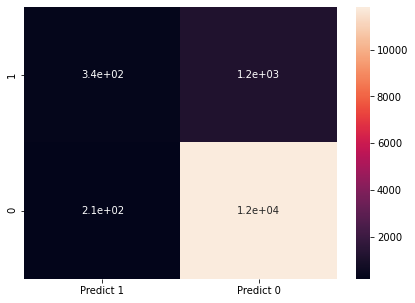

In [210]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_predict, labels=[0, 1])

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

In [167]:
# Calculating feature importance using predefined function
ft_importance = dt_pruned.tree_.compute_feature_importances(normalize=False)
ft_imp_dict = dict(zip(feature_cols, dt_pruned.feature_importances_))
ft_imp = pd.DataFrame.from_dict(ft_imp_dict, orient='index')
ft_imp.sort_values(by=0, ascending=False) # Sorting in descending order of importance

,0
duration,0.548767
poutcome,0.370845
age,0.055117
contact_unknown,0.025271
balance,0.000000
job_housemaid,0.000000
contact_telephone,0.000000
contact_cellular,0.000000
job_unknown,0.000000
job_unemployed,0.000000


#### *Insight*: The features duration, age, poutcome and contact_unknown are the only ones which impact the Target variable (whether the target subscribes the term deposit or not)

#### 1.ii. b. Logistic Regression 

       age  marital  education  default  balance  duration  campaign  pdays  \
35272   39        0          2        0     4239        40         1    900   
10705   44        1          2        0      647       226         2    900   
43536   46        2          0        0      429       465         2    369   
6960    55        1          0        0       81       172         1    900   
41892   28        1          1        0      172       123         2    900   

       poutcome  
35272        -1  
10705        -1  
43536         1  
6960         -1  
41892        -1  
0    39922
1     5289
Name: Target, dtype: int64
70.00% data is in training set
30.00% data is in test set
0.8964169861397818
The accuracy score is :  0.8964169861397818
The sensitivity (True positive rate) of the data fit model is :  0.2183833116036506
The specificity (True negative rate) of the data fit model is :  0.9828761429758937
The precision score is :  0.6192236598890942
The F1score of the data fit model 

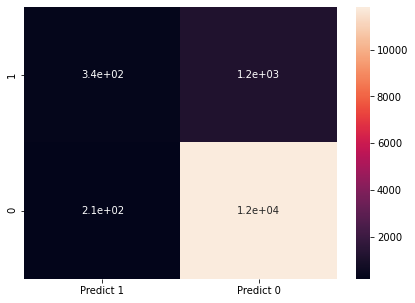

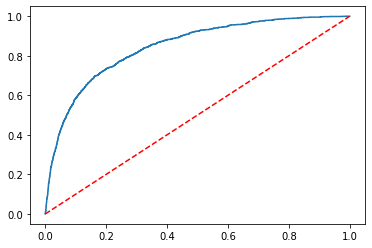

In [211]:
Xl = data2.drop('Target', axis=1)
Yl = data['Target']
xl_train, xl_test, yl_train, yl_test = train_test_split(Xl, Yl, test_size=0.3, random_state=7)
print(xl_train.head())
print(data['Target'].value_counts())
print("{0:0.2f}% data is in training set".format((len(xl_train)/len(data2.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(xl_test)/len(data2.index)) * 100))
#data['pdays'].describe()

# model fitting
model = linear_model.LogisticRegression(random_state=42, penalty='l1',solver='liblinear', C=1) # newton-cg was tried and gave a partially better model score (usually used for multiclass problems)
yl_train = yl_train.astype(int) # Converting y_train values to int as float values are not excepted
yl_test = yl_test.astype(int) # Converting y_train values to int as float values are not excepted
model.fit(xl_train, yl_train)

# model score
yl_predict = model.predict(xl_test)
print(model.score(xl_test, yl_test))

# confusion matrix
conf_mat = metrics.confusion_matrix(yl_test, yl_predict, labels=[1, 0])

df_conf_mat = pd.DataFrame(conf_mat, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_conf_mat, annot=True)

# printing all metrics to compute accuracy, sensitivity, specificity and precision of Logistic Regression
TP = df_conf_mat['Predict 1'][0]
TN = df_conf_mat['Predict 0'][1]
FP = df_conf_mat['Predict 1'][1]
FN = df_conf_mat['Predict 0'][0]
accuracy_score_lr = (TP+TN)/(TP+TN+FP+FN)
print('The accuracy score is : ',accuracy_score_lr)

sensitivity_lr = (TP)/(TP+FN)
print('The sensitivity (True positive rate) of the data fit model is : ',sensitivity_lr)

specificity = (TN)/(TN+FP)
print('The specificity (True negative rate) of the data fit model is : ',specificity)

precision_lr = (TP)/(TP+FP)
print('The precision score is : ',precision_lr)

F1score_lr = 2*(precision*sensitivity)/(precision+sensitivity)
print('The F1score of the data fit model is :', F1score_lr)

plt.figure()
logit_roc_auc = roc_auc_score(yl_test, model.predict(xl_test))
fpr, tpr, thresholds = roc_curve(yl_test, model.predict_proba(xl_test)[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression (area= %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.savefig('Log_ROC')
plt.show()

In [240]:
# Dataframe for storing data for both Logistic regression and Decision tree
'''Storing the decision tree accuracy data in a dataframe'''
accresdf = pd.DataFrame({'Method':['Decision Tree', 'Logistic regression'], 'Accuracy':[acc_dt, accuracy_score_lr],'Recall':[recall_dt, sensitivity_lr] ,'Precision':[precis_dt, precision_lr] ,'F1score':[f1_dt, F1score_lr]})
accresdf = accresdf[['Method','Accuracy', 'Recall', 'Precision', 'F1score']]
accresdf

,Method,Accuracy,Recall,Precision,F1score
0,Decision Tree,0.899735,0.317471,0.608750,0.417309
1,Logistic regression,0.896417,0.218383,0.619224,0.322892


## 2. Ensemble learning techniques

### a. Bagging

0.9003981126511353
Accuracy score Bagging:  0.9003981126511353
Recall score Bagging:  0.37222946544980445
Precision score Bagging:  0.5954118873826904
F1 score Bagging:  0.45808263136783


,Method,Accuracy,Recall,Precision,F1score
0,Decision Tree,0.899735,0.317471,0.608750,0.417309
1,Logistic regression,0.896417,0.218383,0.619224,0.322892
0,Bagging,0.900398,0.372229,0.595412,0.458083


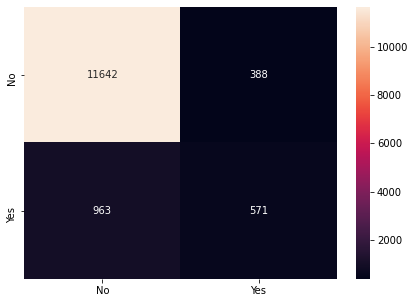

In [241]:
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(base_estimator=dt_pruned, n_estimators=50,random_state=1)
bgcl = bgcl.fit(x_train, y_train)
y_predict_bcgl = bgcl.predict(x_test)
print(bgcl.score(x_test , y_test))
cm=metrics.confusion_matrix(y_test, y_predict,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

ascore_bag=accuracy_score(y_test, y_predict_bcgl)
recall_bag=recall_score(y_test, y_predict_bcgl)
precis_bag=precision_score(y_test, y_predict_bcgl)
f1_bag=f1_score(y_test, y_predict_bcgl)

print('Accuracy score Bagging: ', ascore_bag)
print('Recall score Bagging: ', recall_bag)
print('Precision score Bagging: ', precis_bag)
print('F1 score Bagging: ', f1_bag)

tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'Accuracy':[ascore_bag],'Recall':[recall_bag] ,'Precision':[precis_bag] ,'F1score':[f1_bag]})
accresdf = pd.concat([accresdf, tempResultsDf])
accresdf = accresdf[['Method','Accuracy', 'Recall', 'Precision', 'F1score']]
accresdf

### b. Adaptive Boosting

0.9008404600412857
Accuracy score AdaBoosting:  0.9008404600412857
Recall score AdaBoosting:  0.41199478487614083
Precision score AdaBoosting:  0.587906976744186
F1 score AdaBoosting:  0.48447681103871215


,Method,Accuracy,Recall,Precision,F1score
0,Decision Tree,0.899735,0.317471,0.608750,0.417309
1,Logistic regression,0.896417,0.218383,0.619224,0.322892
0,Bagging,0.900398,0.372229,0.595412,0.458083
0,Adaptive boosting,0.900840,0.411995,0.587907,0.484477


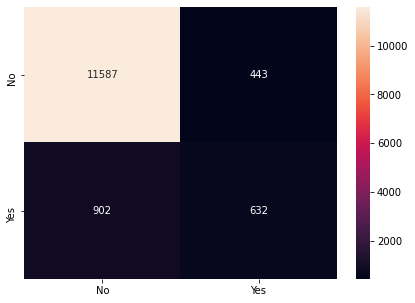

In [242]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(base_estimator=dt_pruned, n_estimators=10,random_state=1)
abc = abc.fit(x_train, y_train)
y_predict_abc = abc.predict(x_test)
print(abc.score(x_test , y_test))
cm=metrics.confusion_matrix(y_test, y_predict_abc,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

ascore_abc=accuracy_score(y_test, y_predict_abc)
recall_abc=recall_score(y_test, y_predict_abc)
precis_abc=precision_score(y_test, y_predict_abc)
f1_abc=f1_score(y_test, y_predict_abc)

print('Accuracy score AdaBoosting: ', ascore_abc)
print('Recall score AdaBoosting: ', recall_abc)
print('Precision score AdaBoosting: ', precis_abc)
print('F1 score AdaBoosting: ', f1_abc)

tempResultsDf = pd.DataFrame({'Method':['Adaptive boosting'], 'Accuracy':[ascore_abc],'Recall':[recall_abc] ,'Precision':[precis_abc] ,'F1score':[f1_abc]})
accresdf = pd.concat([accresdf, tempResultsDf])
accresdf = accresdf[['Method','Accuracy', 'Recall', 'Precision', 'F1score']]
accresdf

### c. Gradient Boosting

0.9074756708935418
Accuracy score Gradient boosting:  0.9074756708935418
Recall score Gradient boosting:  0.3617992177314211
Precision score Gradient boosting:  0.6678700361010831
F1 score Gradient boosting:  0.46934460887949264


,Method,Accuracy,Recall,Precision,F1score
0,Decision Tree,0.899735,0.317471,0.608750,0.417309
1,Logistic regression,0.896417,0.218383,0.619224,0.322892
0,Bagging,0.900398,0.372229,0.595412,0.458083
0,Adaptive boosting,0.900840,0.411995,0.587907,0.484477
0,Gradient boosting,0.907476,0.361799,0.667870,0.469345
0,Gradient boosting,0.907476,0.361799,0.667870,0.469345


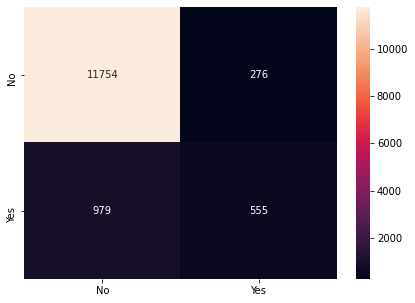

In [244]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbc = gbc.fit(x_train, y_train)
y_predict_gbc = gbc.predict(x_test)
print(gbc.score(x_test , y_test))
cm=metrics.confusion_matrix(y_test, y_predict_gbc,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

ascore_gbc=accuracy_score(y_test, y_predict_gbc)
recall_gbc=recall_score(y_test, y_predict_gbc)
precis_gbc=precision_score(y_test, y_predict_gbc)
f1_gbc=f1_score(y_test, y_predict_gbc)

print('Accuracy score Gradient boosting: ', ascore_gbc)
print('Recall score Gradient boosting: ', recall_gbc)
print('Precision score Gradient boosting: ', precis_gbc)
print('F1 score Gradient boosting: ', f1_gbc)

tempResultsDf = pd.DataFrame({'Method':['Gradient boosting'], 'Accuracy':[ascore_gbc],'Recall':[recall_gbc] ,'Precision':[precis_gbc] ,'F1score':[f1_gbc]})
accresdf = pd.concat([accresdf, tempResultsDf])
accresdf = accresdf[['Method','Accuracy', 'Recall', 'Precision', 'F1score']]
accresdf

### d. Random Forest

0.9049690356826895
Accuracy score Gradient boosting:  0.9049690356826895
Recall score Gradient boosting:  0.3748370273794003
Precision score Gradient boosting:  0.6353591160220995
F1 score Gradient boosting:  0.4715047150471506


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


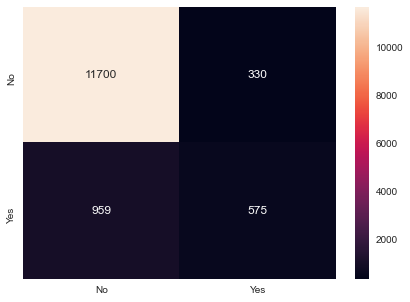

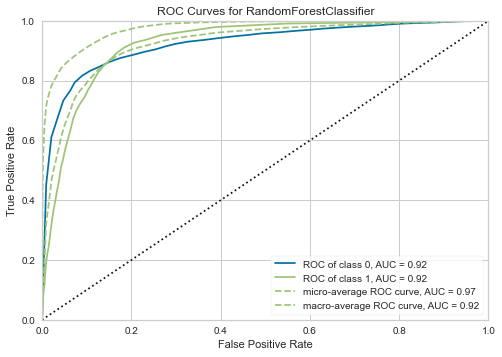

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [251]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50)
rfc = rfc.fit(x_train, y_train)
y_predict_rfc = rfc.predict(x_test)
print(rfc.score(x_test , y_test))
cm=metrics.confusion_matrix(y_test, y_predict_rfc,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

ascore_rfc=accuracy_score(y_test, y_predict_rfc)
recall_rfc=recall_score(y_test, y_predict_rfc)
precis_rfc=precision_score(y_test, y_predict_rfc)
f1_rfc=f1_score(y_test, y_predict_rfc)

print('Accuracy score Gradient boosting: ', ascore_rfc)
print('Recall score Gradient boosting: ', recall_rfc)
print('Precision score Gradient boosting: ', precis_rfc)
print('F1 score Gradient boosting: ', f1_rfc)

plt.figure()
roc = ROCAUC(RandomForestClassifier(n_estimators = 50))
roc.fit(x_train, y_train)
roc.score(x_test, y_test)
roc.show()

In [245]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'Accuracy':[ascore_rfc],'Recall':[recall_rfc] ,'Precision':[precis_rfc] ,'F1score':[f1_rfc]})
accresdf = pd.concat([accresdf, tempResultsDf])
accresdf = accresdf[['Method','Accuracy', 'Recall', 'Precision', 'F1score']]
accresdf

,Method,Accuracy,Recall,Precision,F1score
0,Decision Tree,0.899735,0.317471,0.608750,0.417309
1,Logistic regression,0.896417,0.218383,0.619224,0.322892
0,Bagging,0.900398,0.372229,0.595412,0.458083
0,Adaptive boosting,0.900840,0.411995,0.587907,0.484477
0,Gradient boosting,0.907476,0.361799,0.667870,0.469345
0,Gradient boosting,0.907476,0.361799,0.667870,0.469345
0,Random Forest,0.904232,0.353325,0.638398,0.454889


# Conclusion
### 1. 